In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



CLEANING & PRE-PROCESSING

In [13]:


# Load dataset
df = pd.read_csv('delhiaqi.csv')

# Parse datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)

# Keep only CPCB pollutants present
rename_map = {
    'pm2_5': 'PM2.5',
    'pm10': 'PM10',
    'no2': 'NO2',
    'so2': 'SO2',
    'o3': 'O3',
    'co': 'CO',
    'nh3': 'NH3',
}
df = df[['date'] + [c for c in rename_map.keys() if c in df.columns]].rename(columns=rename_map)

# Remove negatives (invalid values)
for col in [c for c in df.columns if c != 'date']:
    df.loc[df[col] < 0, col] = np.nan

# Convert CO μg/m3 -> mg/m3
if 'CO' in df.columns:
    df['CO_mg'] = df['CO'] / 1000.0




CPCB(Central Pollution Control Board) NAQI Breakpoints

In [14]:

BP = {
    'PM10': [(0, 50, 0, 50),(51, 100, 51, 100),(101, 250, 101, 200),(251, 350, 201, 300),
             (351, 430, 301, 400),(431, 100000, 401, 500)],
    'PM2.5': [(0, 30, 0, 50),(31, 60, 51, 100),(61, 90, 101, 200),(91, 120, 201, 300),
              (121, 250, 301, 400),(251, 100000, 401, 500)],
    'NO2': [(0, 40, 0, 50),(41, 80, 51, 100),(81, 180, 101, 200),(181, 280, 201, 300),
            (281, 400, 301, 400),(401, 100000, 401, 500)],
    'SO2': [(0, 40, 0, 50),(41, 80, 51, 100),(81, 380, 101, 200),(381, 800, 201, 300),
            (801, 1600, 301, 400),(1601, 100000, 401, 500)],
    'O3': [(0, 50, 0, 50),(51, 100, 51, 100),(101, 168, 101, 200),(169, 208, 201, 300),
           (209, 748, 301, 400),(749, 100000, 401, 500)],
    'CO_mg': [(0.0, 1.0, 0, 50),(1.1, 2.0, 51, 100),(2.1, 10.0, 101, 200),
              (10.1, 17.0, 201, 300),(17.1, 34.0, 301, 400),(34.1, 1000.0, 401, 500)],
    'NH3': [(0, 200, 0, 50),(201, 400, 51, 100),(401, 800, 101, 200),(801, 1200, 201, 300),
            (1201, 1800, 301, 400),(1801, 100000, 401, 500)],
}

def sub_index(pollutant, Cp):
    if pd.isna(Cp):
        return np.nan
    for (Bplo, Bphi, Ilo, Ihi) in BP[pollutant]:
        if Bplo <= Cp <= Bphi:
            return (Ihi - Ilo) / (Bphi - Bplo) * (Cp - Bplo) + Ilo
    return 500.0




Daily AQI Computation

In [15]:

df = df.set_index('date')

polls_24h = [p for p in ['PM10','PM2.5','NO2','SO2','NH3'] if p in df.columns]
polls_8h = [p for p in ['O3'] if p in df.columns]
co_key = 'CO_mg' if 'CO_mg' in df.columns else None

# Daily averages (24h)
daily_24h = df[polls_24h].resample('D').mean()

# Daily max of 8h averages
daily_8h = pd.DataFrame(index=daily_24h.index)
if 'O3' in polls_8h:
    o3_roll = df['O3'].rolling('8H', min_periods=6).mean()
    daily_8h['O3'] = o3_roll.resample('D').max()
if co_key:
    co_roll = df[co_key].rolling('8H', min_periods=6).mean()
    daily_8h['CO_mg'] = co_roll.resample('D').max()

# Merge
daily = daily_24h.join(daily_8h, how='outer')

# Sub-indices
subidx_cols = []
for col in daily.columns:
    if col in BP:
        sub_col = f'{col}_subindex'
        daily[sub_col] = daily[col].apply(lambda x: sub_index(col, x))
        subidx_cols.append(sub_col)

# Final AQI
def row_aqi_and_dominant(row):
    vals = row[subidx_cols]
    aqi = np.nanmax(vals.values) if vals.notna().any() else np.nan
    if np.isnan(aqi): return pd.Series([np.nan, np.nan])
    dom = vals.idxmax().replace('_subindex','')
    return pd.Series([round(aqi,0), dom])

daily[['AQI','Dominant']] = daily.apply(row_aqi_and_dominant, axis=1)

# Category labels
def category(aqi):
    if pd.isna(aqi): return np.nan
    if aqi <= 50: return 'Good'
    if aqi <= 100: return 'Satisfactory'
    if aqi <= 200: return 'Moderate'
    if aqi <= 300: return 'Poor'
    if aqi <= 400: return 'Very Poor'
    return 'Severe'

daily['Category'] = daily['AQI'].apply(category)



/tmp/ipykernel_8538/1779130756.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  o3_roll = df['O3'].rolling('8H', min_periods=6).mean()
/tmp/ipykernel_8538/1779130756.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  co_roll = df[co_key].rolling('8H', min_periods=6).mean()



Visualization

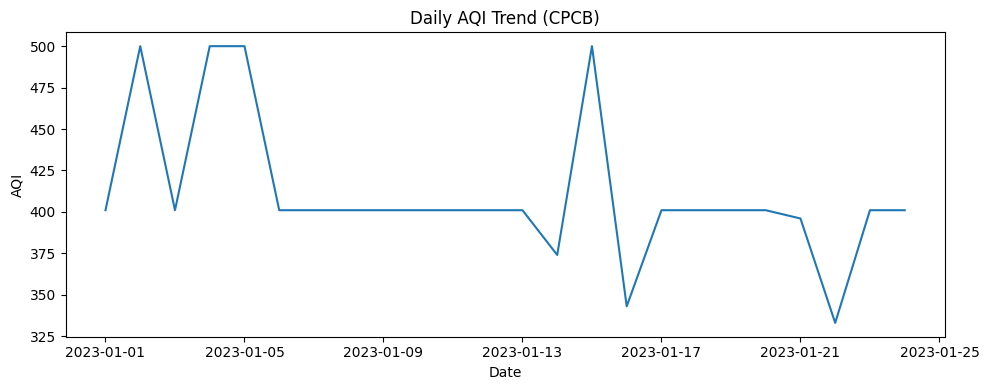

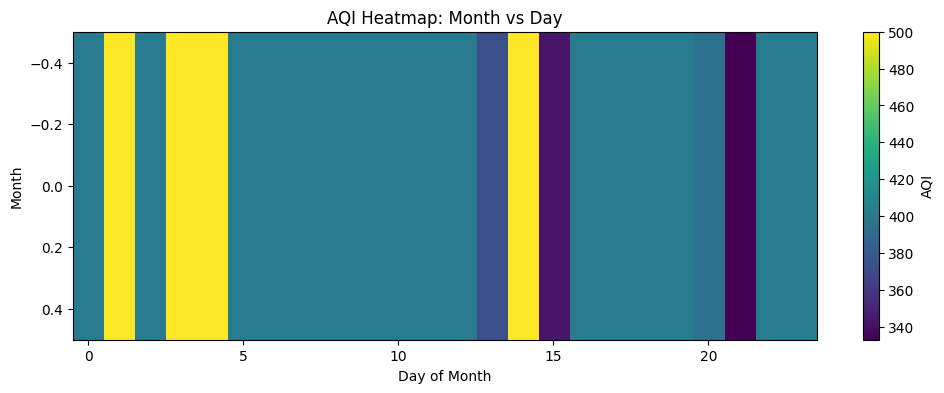

In [16]:

plt.figure(figsize=(10,4))
plt.plot(daily.index, daily['AQI'])
plt.title('Daily AQI Trend (CPCB)')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.tight_layout()
plt.show()

hm = daily.copy()
hm['Month'] = hm.index.month
hm['Day'] = hm.index.day
pivot = hm.pivot_table(index='Month', columns='Day', values='AQI', aggfunc='mean')

plt.figure(figsize=(12,4))
plt.imshow(pivot.values, aspect='auto', interpolation='nearest')
plt.title('AQI Heatmap: Month vs Day')
plt.xlabel('Day of Month')
plt.ylabel('Month')
plt.colorbar(label='AQI')
plt.show()




Benchmark Summary

In [17]:

summary = (
    daily['Category']
    .value_counts(dropna=True)
    .reindex(['Good','Satisfactory','Moderate','Poor','Very Poor','Severe'])
    .fillna(0)
    .astype(int)
    .rename('Days')
    .reset_index()
    .rename(columns={'index':'Category'})
)

print("AQI Category Summary:")
print(summary)

# Save results
daily.to_csv('delhi_daily_aqi_cpcb.csv', index_label='date')
summary.to_csv('delhi_aqi_category_summary.csv', index=False)


AQI Category Summary:
       Category  Days
0          Good     0
1  Satisfactory     0
2      Moderate     0
3          Poor     0
4     Very Poor     4
5        Severe    20


## Conclusion

The Air Quality Index (AQI) analysis for Delhi highlights the persistent challenge of air pollution in the city.  
The majority of days fall into the **Moderate to Very Poor** categories, with several instances of **Severe** pollution levels, primarily driven by high concentrations of **PM2.5** and **PM10**.  
Seasonal variations are evident, with pollution levels peaking during winter months due to factors like stubble burning, lower wind speeds, and temperature inversions.  

While occasional days register as **Satisfactory**, the overall trend indicates that Delhi consistently exceeds the safe thresholds defined by CPCB.  
This underscores the urgent need for **targeted interventions** such as stricter emission controls, promotion of cleaner fuels, regulation of vehicular traffic, and large-scale afforestation to mitigate particulate pollution.  

In summary, the AQI trends reaffirm that improving Delhi’s air quality requires sustained policy measures, public awareness, and regional cooperation to safeguard public health and ensure environmental sustainability.
